# M. Caiola, L. Cusin, G. Serafini, A. Tonello 

# Dataset


The pathology and hematology departments at Libya's Sebha Oncology Center; embody the spatial boundaries of a study. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were all Libyan cases from different regions who were registered during the study at the SOC.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

The role of biomarkers in diagnosing breast cancer:

 1) Early detection  : Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
 3) Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.

Biomarker used in our analysis to discover breast cancer:

CA 15-3 : These are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for VIF calculation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [73]:
file_path = './BC.csv'
# file_path = './data/BC.csv'
data = pd.read_csv(file_path)

data.head()

,Sex,Age,Adress,FBS,Urea,Creatinin,ALB,T_Ca,GPT,GOT,...,WBC,RBC,HGB,PLT,ESR,LDH,Na,K,CL,CLASS
0,1,60,Tragan,100,23,0.80000000,3.40000000,10.00000000,20,10,...,3.40000000,4.60000000,13.40000000,196,14,150,145.00000000,4.50000000,107.10000000,0
1,1,53,Sabha,190,27,0.60000000,4.20000000,9.30000000,11,17,...,4.40000000,5.00000000,12.50000000,155,15,260,139.20000000,4.17000000,106.40000000,0
2,1,50,Sabha,150,15,1.10000000,3.50000000,8.50000000,13,10,...,5.10000000,4.46000000,13.80000000,312,15,169,140.00000000,4.00000000,100.10000000,0
3,1,36,Obaree-center,80,20,1.00000000,4.20000000,8.00000000,7,13,...,3.10000000,4.33000000,10.70000000,212,10,138,136.40000000,4.06000000,107.10000000,0
4,1,30,Obaree-center,80,40,0.80000000,3.00000000,9.50000000,9,15,...,4.20000000,4.13000000,12.30000000,243,5,154,142.30000000,4.00000000,106.20000000,0


This is a brief description of the variables:

1. **Sex**: Biological sex of the individual (e.g., 1 = Male, 2 = Female)

2. **Age**: Age of the individual in years
3. **Adress**: Location or residence of the individual (likely categorical)
4. **FBS**: Fasting Blood Sugar (mg/dL), a measure of blood glucose after fasting.
5. **Urea**: Blood urea level (mg/dL), a measure of kidney function.
6. **Creatinin**: Serum creatinine level (mg/dL), a marker for kidney function.
7. **ALB**: Albumin (g/dL), a protein in the blood, indicative of liver or kidney health.
8. **T_Ca**: Total Calcium (mg/dL), important for bone health and metabolic functions.
9. **GPT (ALT)**: Alanine Aminotransferase (U/L), a liver enzyme used to assess liver function.
10. **GOT (AST)**: Aspartate Aminotransferase (U/L), another liver enzyme indicative of liver health.
11. **ALP**: Alkaline Phosphatase (U/L), a liver and bone enzyme.
12. **CA15**: Cancer Antigen 15-3 (U/mL), often used as a tumor marker for breast cancer.
13. **CEA**: Carcinoembryonic Antigen (ng/mL), a marker for various cancers.
14. **WBC**: White Blood Cell count (×10³/µL), a measure of immune system activity.
15. **RBC**: Red Blood Cell count (×10⁶/µL), indicative of oxygen-carrying capacity.
16. **HGB**: Hemoglobin (g/dL), the oxygen-carrying protein in red blood cells.
17. **PLT**: Platelet count (×10³/µL), involved in blood clotting.
18. **ESR**: Erythrocyte Sedimentation Rate (mm/hour), a marker for inflammation.
19. **LDH**: Lactate Dehydrogenase (U/L), an enzyme linked to tissue damage.
20. **Na**: Sodium (mEq/L), an essential electrolyte.
21. **K**: Potassium (mEq/L), another critical electrolyte for muscle and heart function.
22. **CL**: Chloride (mEq/L), an electrolyte that helps maintain fluid balance.
23. **CLASS**: Response variable stating if the cancer if benign or malignant.

 The response variable is $\texttt{CLASS}$: $\quad$ 0 = Benign cancer, 1 = Malignant cancer

# Exploratory Data Analysis

First, we search for missing values

In [74]:
missing_values = data.isnull().sum()
missing_values

Sex          0
Age          0
Adress       0
FBS          0
Urea         0
Creatinin    0
ALB          0
T_Ca         0
GPT          0
GOT          0
ALP          0
CA15         0
CEA          0
WBC          0
RBC          0
HGB          0
PLT          0
ESR          0
LDH          0
Na           0
K            0
CL           0
CLASS        0
dtype: int64

The dataset shows no missing values. We can proceed 

## class_counts = data['CLASS'].value_counts(normalize=True) * 100
print(class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=data, palette= 'viridis', hue = 'CLASS', legend = False)
plt.title('Distribution of the Target Variable (CLASS)')
plt.xlabel('CLASS')
plt.ylabel('Count')
plt.show()

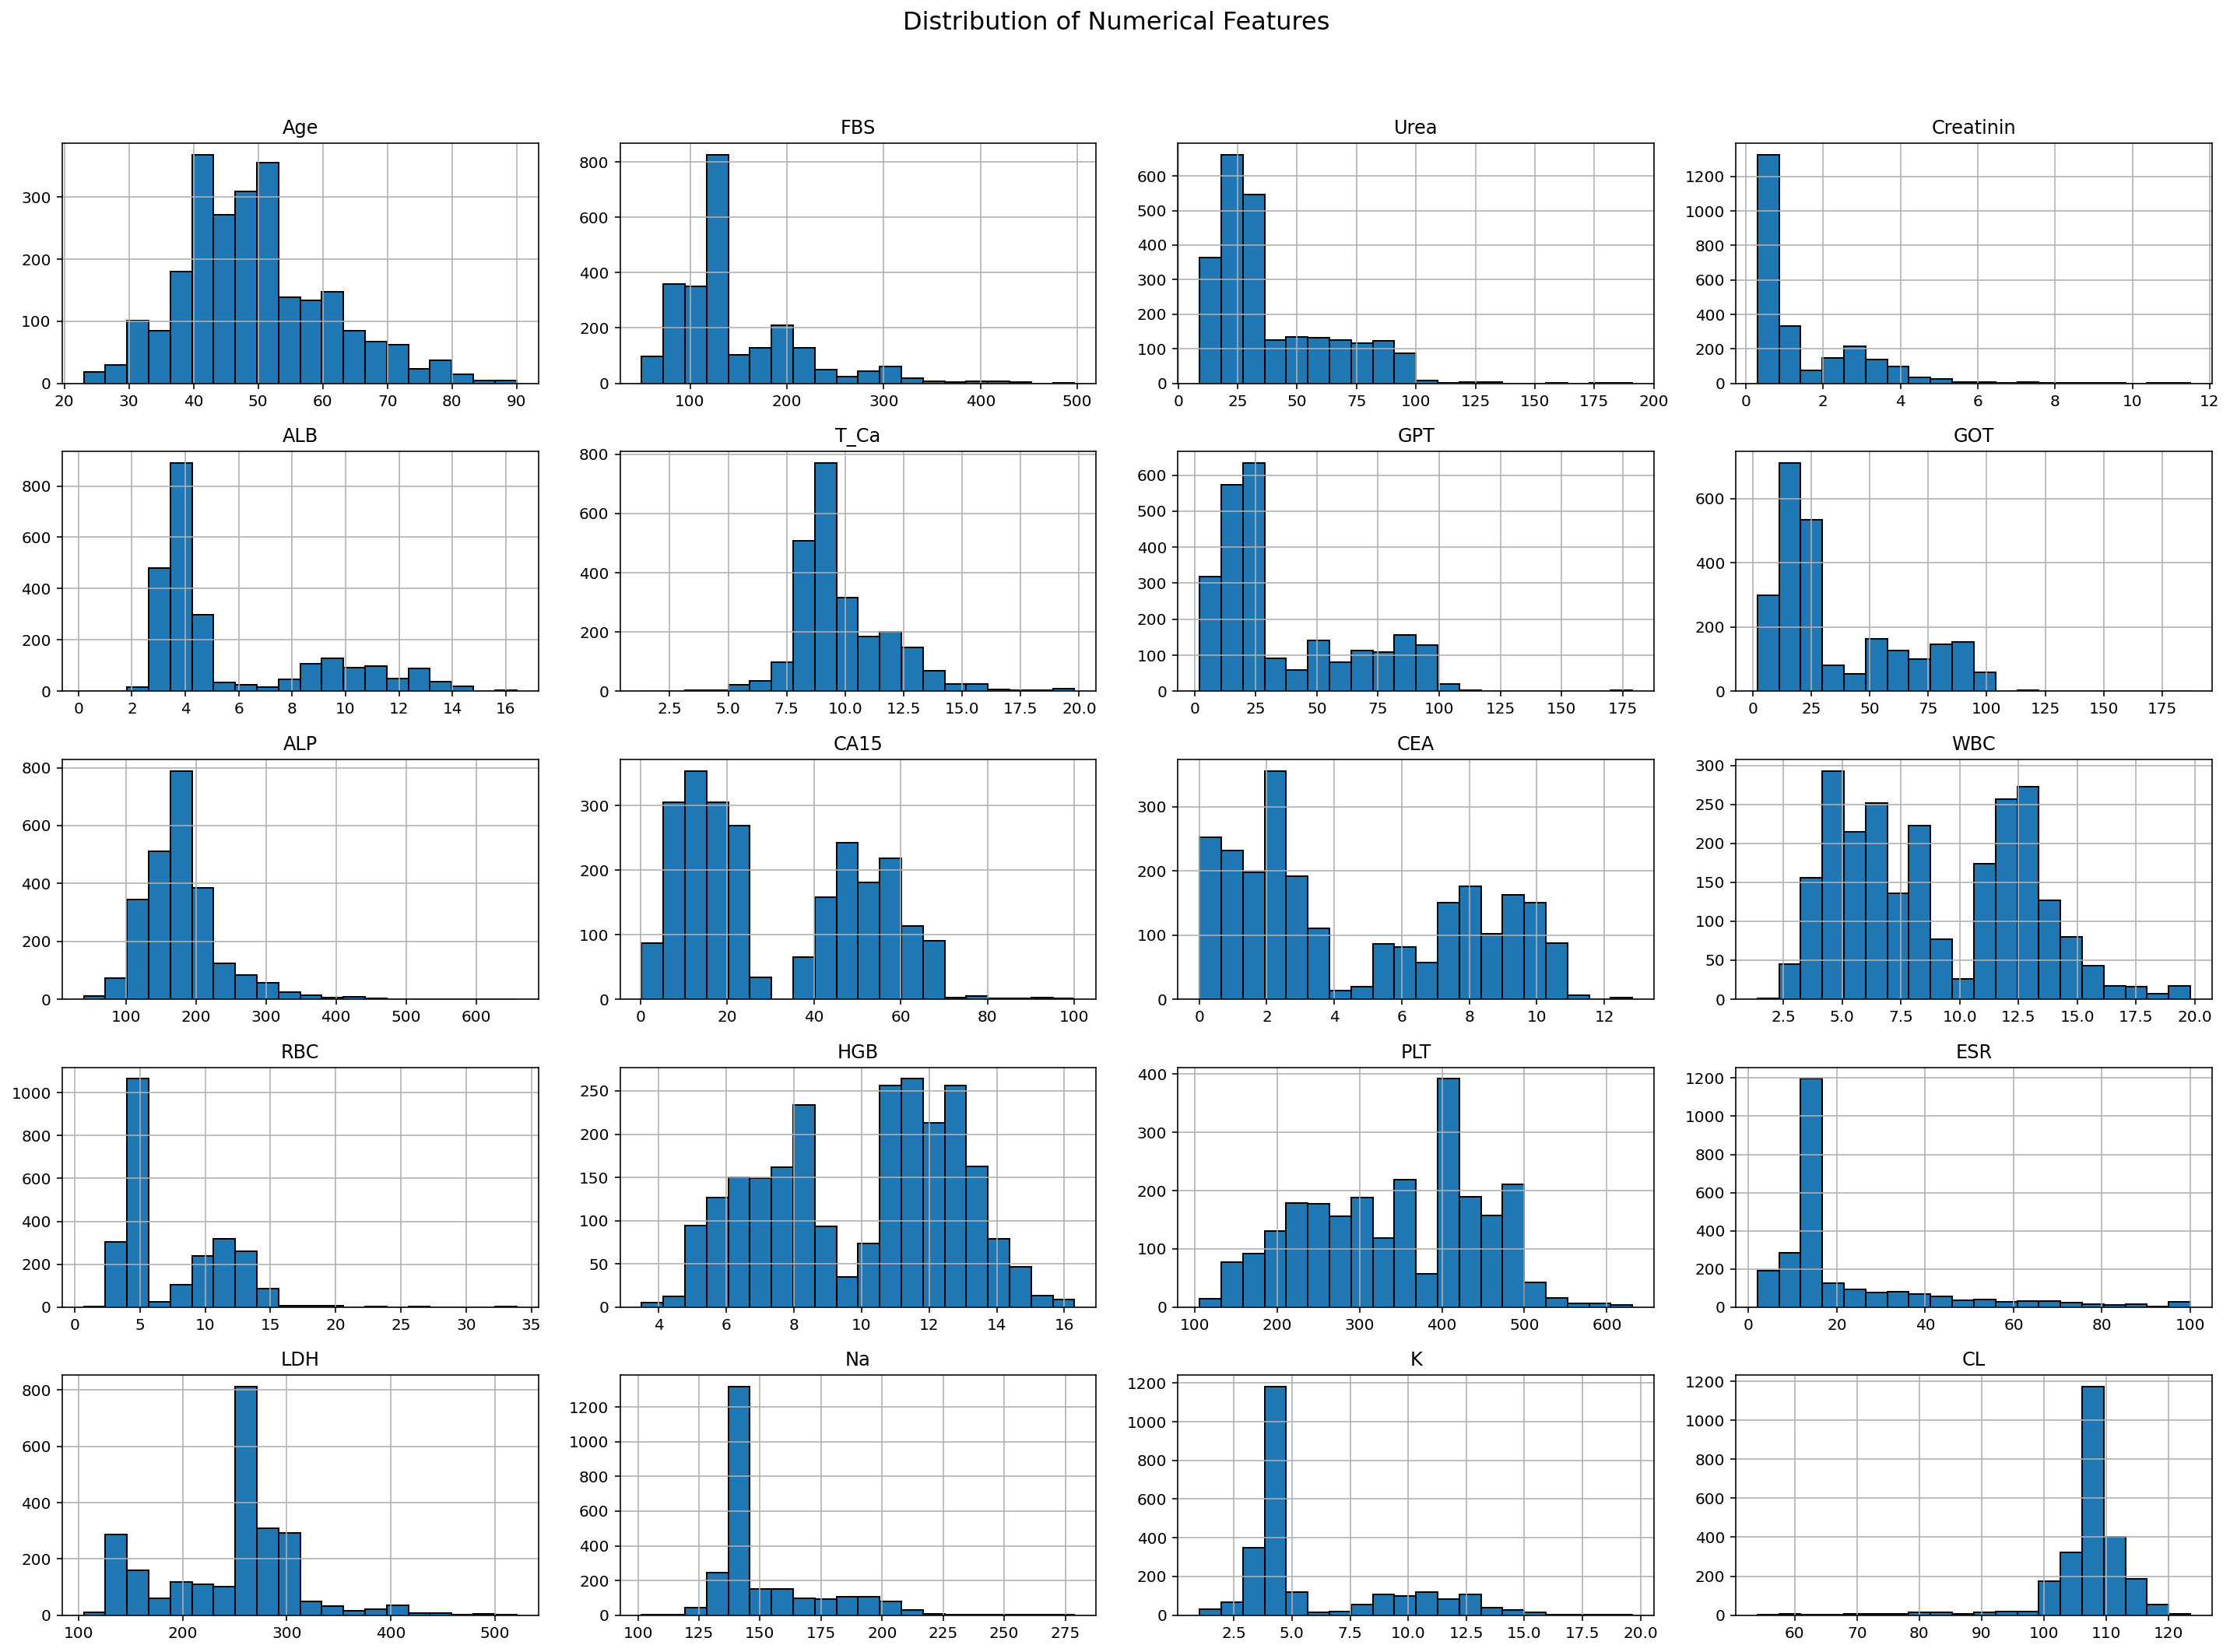

In [75]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['CLASS', 'Sex'])
data[numerical_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Categorization of Variables by Type and Purpose

Categorizing the variables is essential for effectively organizing and interpreting the dataset. Dividing the variables into distinct groups (demographic, biochemical and clinical, and cancer-specific biomarkers) helps identify relevant patterns, analyze significant correlations, and structure the analysis better for predicting the target variable. This segmentation also aids in understanding the role of each variable in the medical and diagnostic context.


## Demographic and categorial variables
Adress  -  Age  -  Sex

### *Adress* 

Given the high number of sampled cities, we chose to categorize them into the three major Libian regions: Tripolitania, Cirenaica and Fezzan

In [76]:
data['Adress'].unique()

array(['Tragan', 'Sabha', 'Obaree-center', 'Alchate', 'Morzek',
       'Alzeegan', 'Algatroon', 'Godoha', 'Zoiwela', 'OmAlrianb',
       'Tripoli', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath',
       'Benwalid', 'Temcian', 'Alzwia-Algrbia', 'Magdool', 'BenGawoad',
       'Alagialt', 'Agdabia', 'GaberOan', 'Subrath', 'ALzentan',
       'Benghazi', 'Tegee', 'Graian', 'Zwoarha', 'sabha'], dtype=object)

In [77]:
# Definizione delle regioni
Tripolitania = [
    'Tripoli', 'Benwalid', 'Subrath', 'ALzentan', 'Tegee', 'Graian', 
    'Zwoarha', 'Alagialt', 'Zoiwela'
]
Cirenaica = [
    'Benghazi', 'Agdabia', 'GaberOan', 'Alzwia-Algrbia', 'Magdool', 
    'BenGawoad', 'Alzeegan'
]
Fezzan = [
    'Sabha', 'sabha' ,'Tragan', 'Obaree-center', 'Alchate', 'Morzek', 'Algatroon', 
    'Godoha', 'OmAlrianb', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath', 'Temcian'
]

# Funzione per classificare le regioni
def classify_region_numeric(adress):
    if adress in Tripolitania:
        return 1  # Tripolitania
    elif adress in Cirenaica:
        return 2  # Cirenaica
    elif adress in Fezzan:
        return 3  # Fezzan


# Applica la funzione alla colonna 'Adress' e assicurati che il risultato sia di tipo intero
data['Adress'] = data['Adress'].apply(classify_region_numeric)

# Visualizza i risultati
#print(data['Adress'])

In [78]:
count_Tripolitania = len(data[(data['Adress'] == 1)])
count_Cirenaica = len(data[(data['Adress'] == 2)])
count_Fezzan = len(data[(data['Adress'] == 3)])
print(count_Tripolitania)
print(count_Cirenaica)
print(count_Fezzan)

88
46
2301


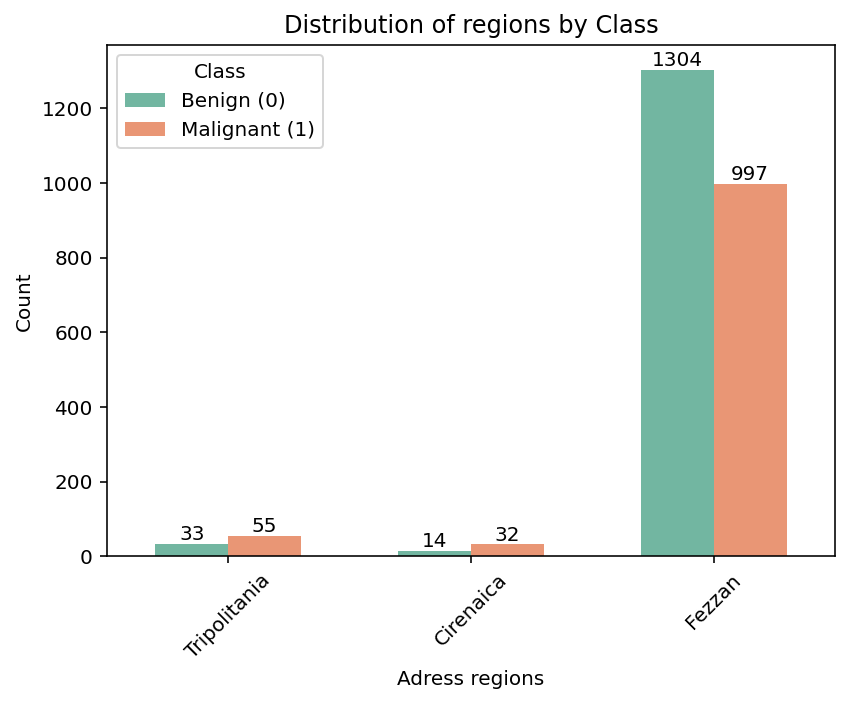

In [79]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=data, x='Adress', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

# Replace x-axis labels with custom names
custom_labels = ['Tripolitania', 'Cirenaica', 'Fezzan']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Distribution of regions by Class')
plt.xlabel('Adress regions')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'], loc="upper left")
plt.tight_layout()

plt.show()

As an initial educated guess, Adress will probably have a small impact on the predictions, since almost all individuals were sampled in the same region (Fezzan)

### *Age da rivedere*

Following a similar reasoning, we also created three major age groups. The thresholds were chosen to reflect known ages brackets. Usually, the most affected individuals are women of older age.

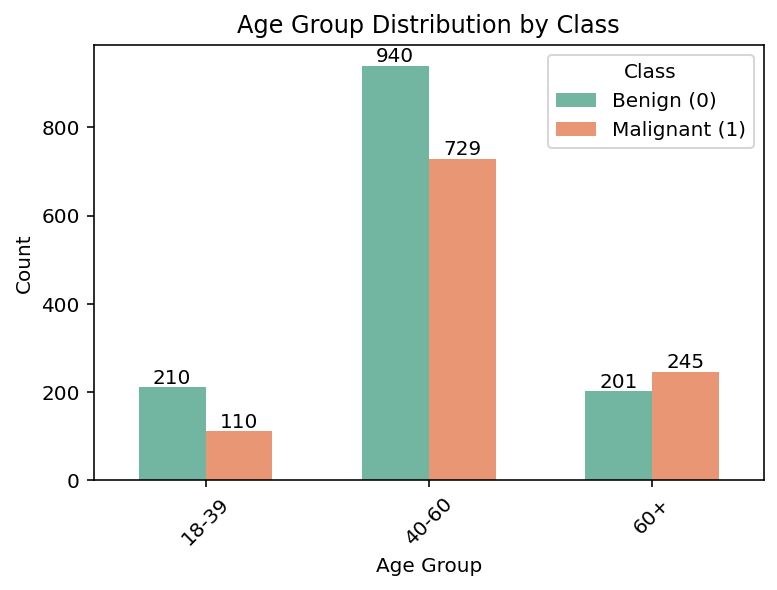

In [80]:
# Define the bins and labels
bins = [18, 39, 60, float('inf')]  # age ranges
labels = [1,2,3]  # 1=18-39, 2=40-60, 3=60+

# Categorize the ages into groups
data['Age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Create the grouped bar plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Age', hue='CLASS', palette='Set2', width=0.6)  # width set to 0.6

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )
# Replace x-axis labels with custom names
custom_labels = ['18-39', '40-60', '60+']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Age Group Distribution by Class')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

The barplots reflect what previously mentioned. Middle-aged people were the most sampled, but breast cancer is more prevalent in individuals aged 60+

### *Sex*

We expect breast cancer to have a much larger impact on female individuals.

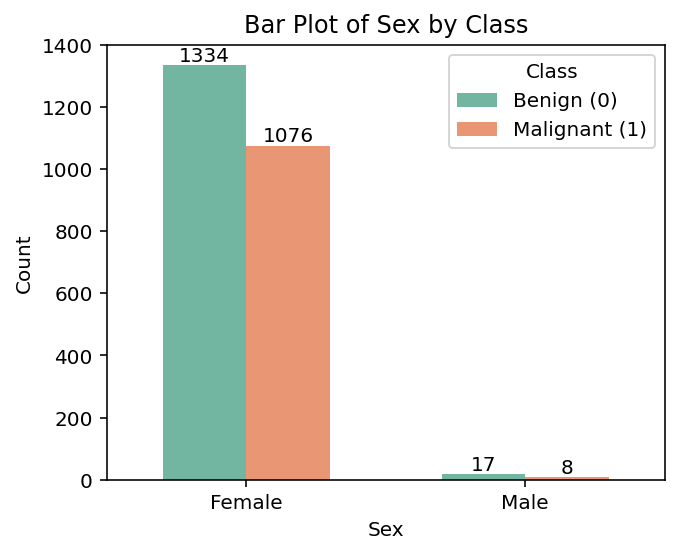

In [81]:
# Create the bar plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=data, x='Sex', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

custom_labels = ['Female', 'Male']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Bar Plot of Sex by Class')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

Almost all sampled individuals are females. Again, we can deduce that the Sex variable won't have much impact on the prediction.

In [82]:
count_class_0 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 0)])
count_class_1 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 1)])

print(count_class_0)
print(count_class_1)

print()
count_class_2 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 0)])
count_class_3 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 1)])
print(count_class_2)
print(count_class_3)


1334
1076

17
8


## Biochemical and Clinical Variables
FBS - Urea - Creatinin - ALB - T_Ca - GPT (ALT) - GOT (AST) - ALP - WBC - RBC - HGB - PLT - ESR - LDH - Na - K - CL

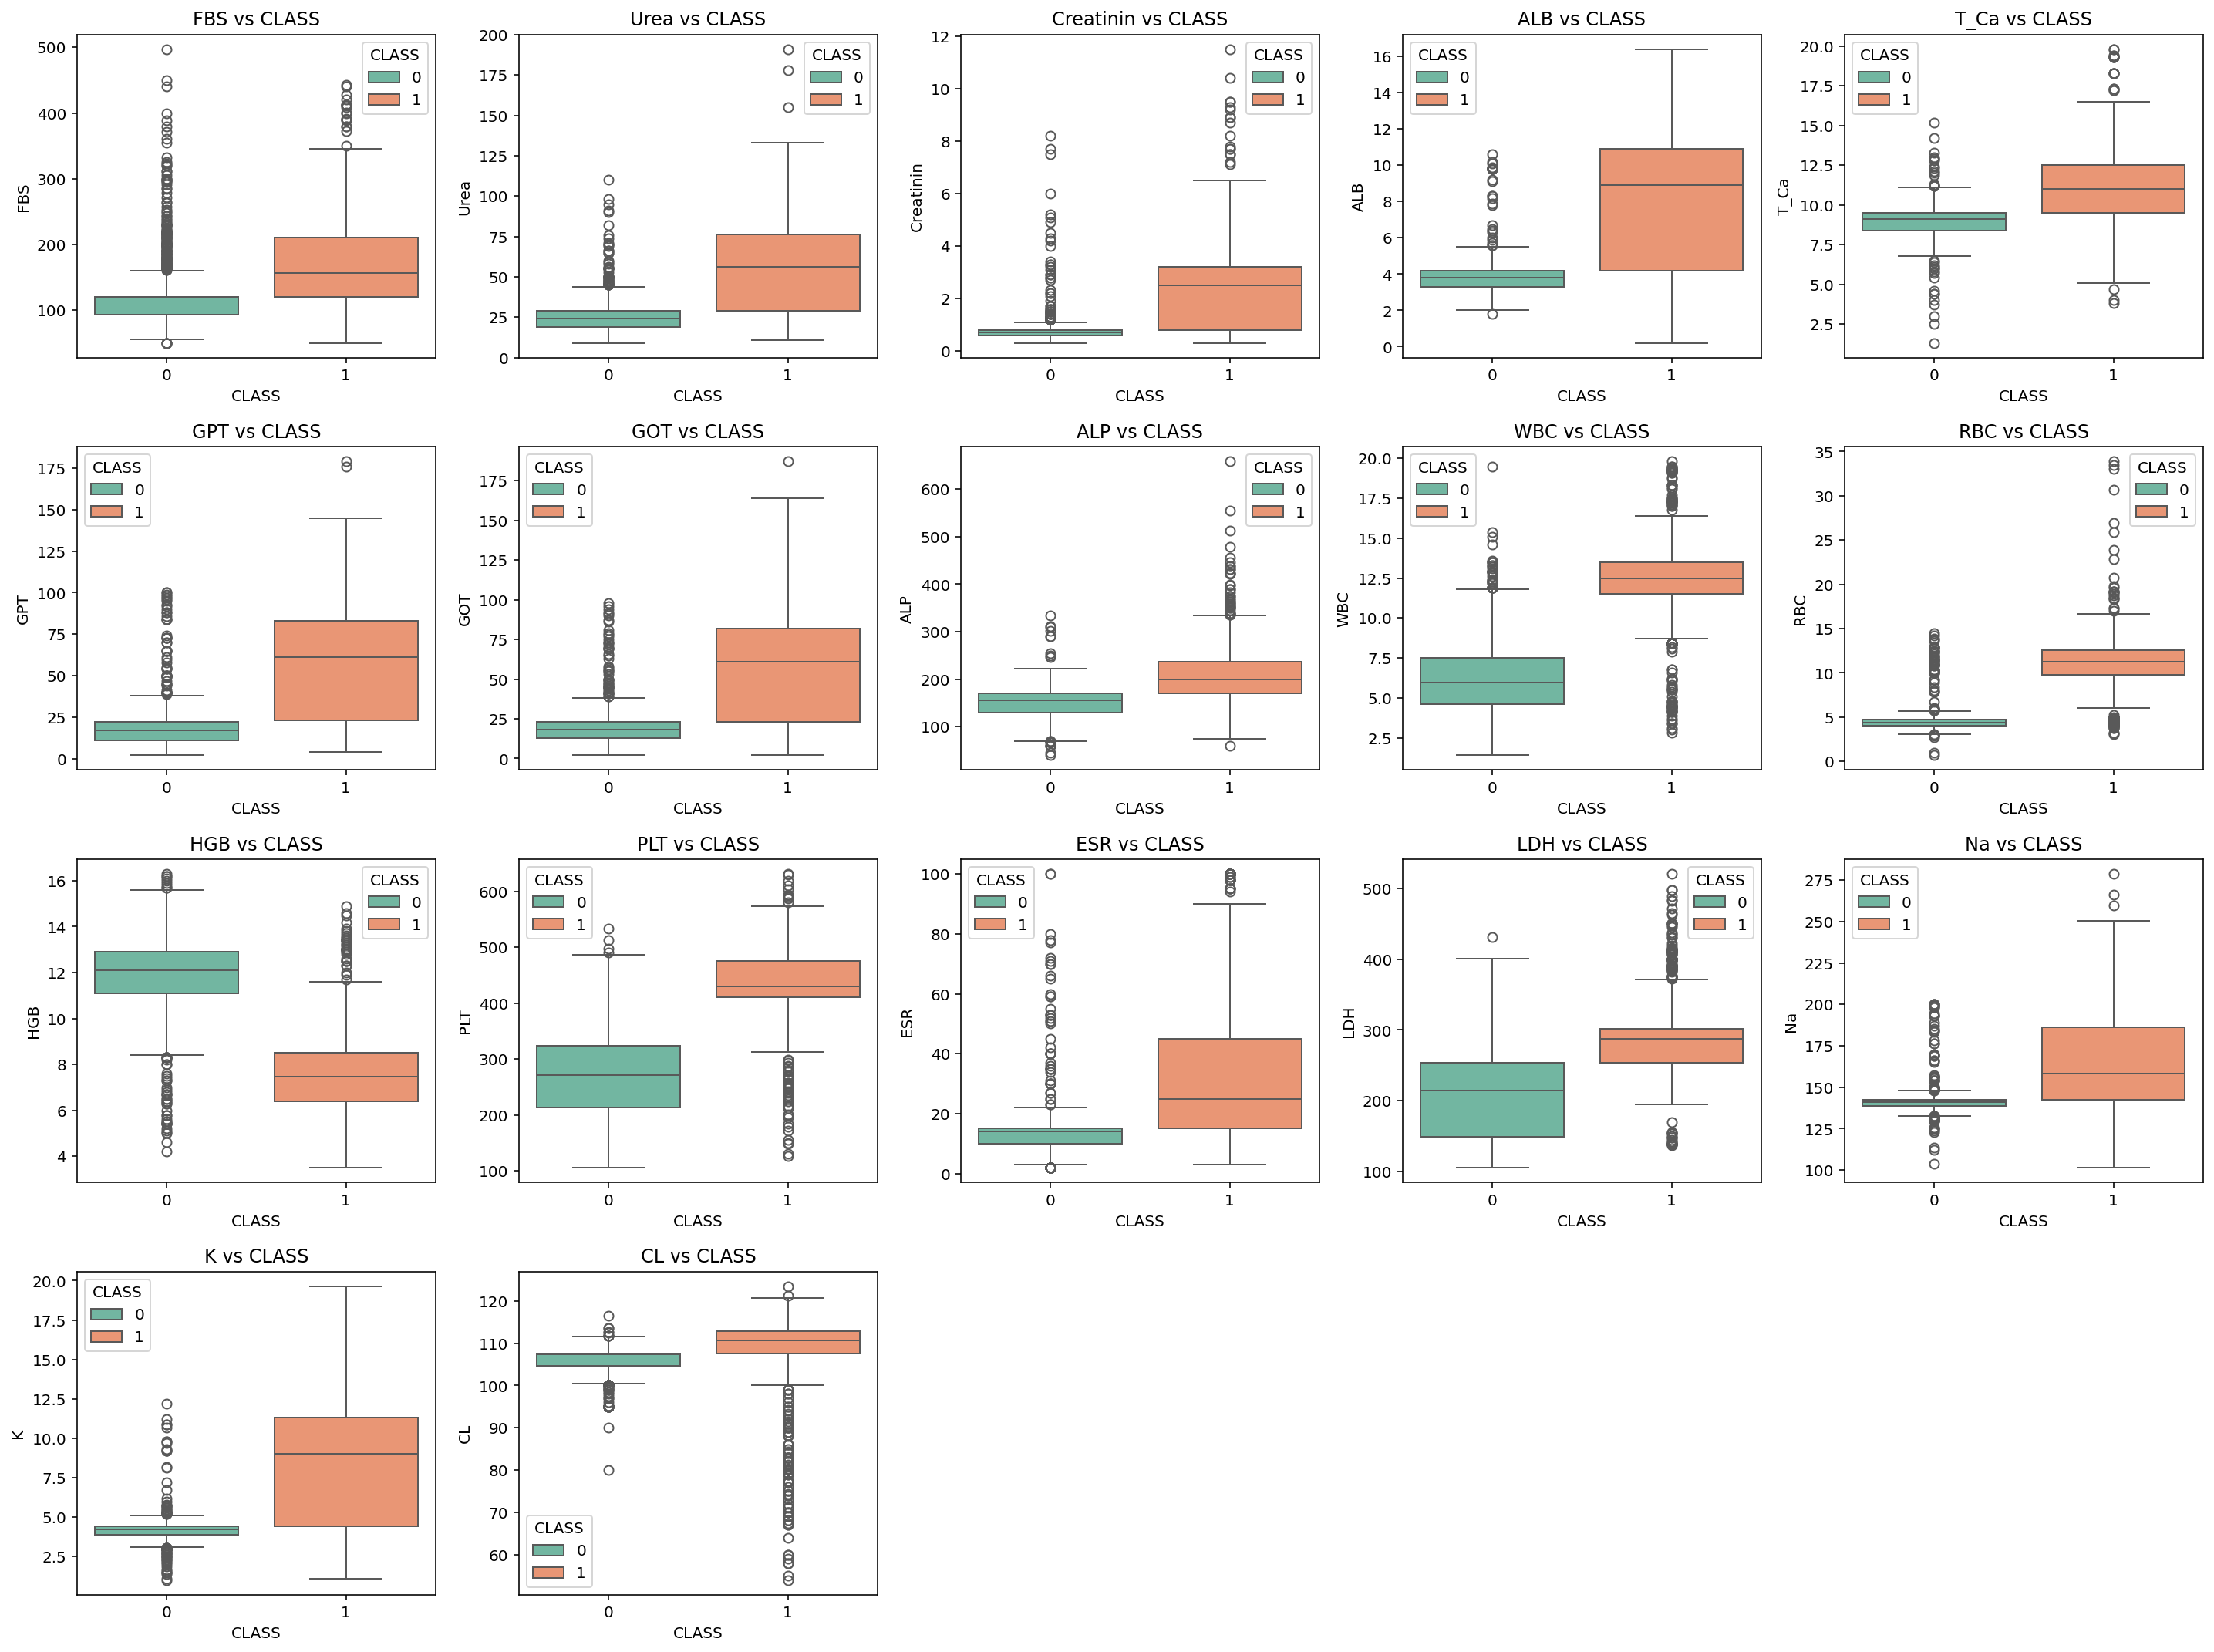

{'Correlations': CLASS        1.00000000
 RBC          0.80628465
 WBC          0.80609838
 PLT          0.75742322
 GOT          0.67476915
 GPT          0.66949497
 ALB          0.66189497
 Urea         0.62810239
 LDH          0.62630742
 K            0.60650982
 Creatinin    0.59189314
 Na           0.54704668
 ALP          0.54250407
 ESR          0.51948740
 T_Ca         0.49933431
 FBS          0.39141785
 CL           0.13949656
 HGB         -0.78914750
 Name: CLASS, dtype: float64}

In [83]:
biochemical_clinical_vars = [
    'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GPT', 'GOT', 'ALP',
    'WBC', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH', 'Na', 'K', 'CL'
]


correlations = data[biochemical_clinical_vars + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)


plt.figure(figsize=(20, 15))
for i, var in enumerate(biochemical_clinical_vars, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(data=data, x='CLASS', y=var, palette="Set2", hue='CLASS')
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(var)
plt.tight_layout()
plt.show()


{
    "Correlations": correlations
}


### Results summary:

The correlation analysis reveals key insights into the relationship between biochemical and clinical variables with the target variable `CLASS` (cancer presence). Variables like **RBC**, **WBC**, and **PLT** show strong positive correlations (>0.75), suggesting that higher levels of these markers are strongly associated with cancer. Similarly, liver function enzymes such as **GOT** and **GPT**, as well as markers like **ALB**, **Urea**, and **LDH**, also demonstrate moderate to strong correlations with `CLASS`, indicating their potential relevance in cancer diagnosis.

Interestingly, **HGB** (Hemoglobin) is the only variable showing a strong negative correlation (-0.79), suggesting that lower levels are indicative of cancer presence. Other variables such as **CL** and **T_Ca** show weak correlations, indicating limited significance in differentiating between `CLASS` values.

These findings highlight the importance of blood markers and biochemical parameters in identifying cancer presence, with some variables (e.g., **RBC**, **WBC**, **PLT**) potentially serving as strong predictors for classification models. Further statistical tests and predictive modeling could refine these observations.

## Cancer Specific Biomarkers
CA15 -  CEA

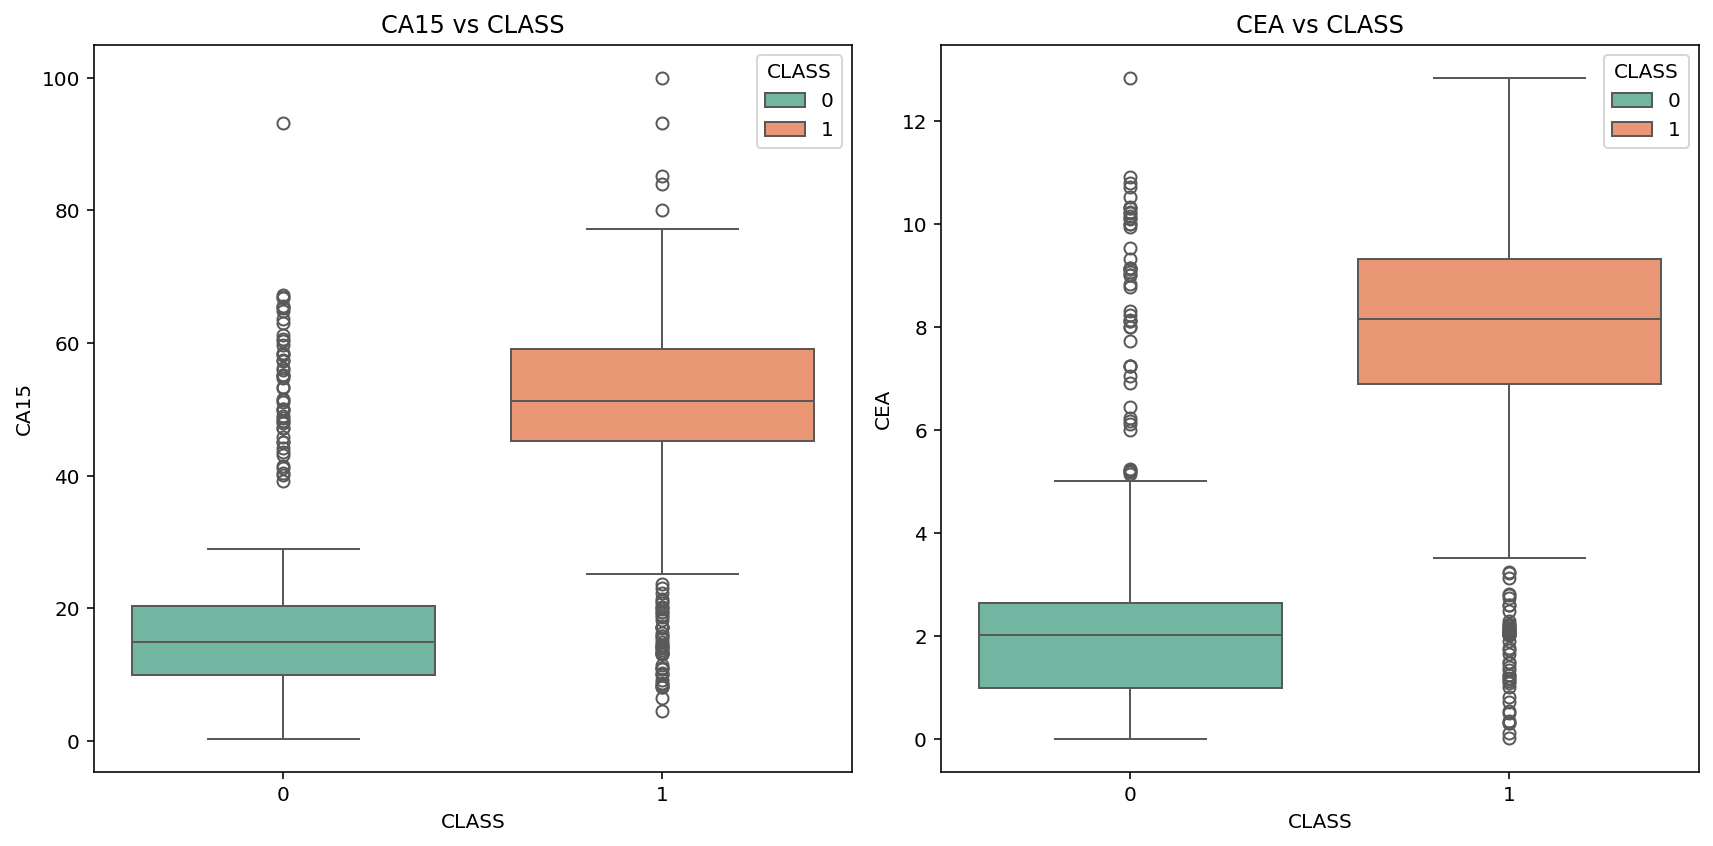

{'Correlations': CLASS   1.00000000
 CA15    0.85228827
 CEA     0.84300994
 Name: CLASS, dtype: float64}

In [84]:
cancer_biomarkers = ['CA15', 'CEA']

# 1. Correlation with CLASS
biomarker_correlations = data[cancer_biomarkers + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)

# 2. Boxplot visualization for each biomarker
plt.figure(figsize=(12, 6))
for i, biomarker in enumerate(cancer_biomarkers, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x='CLASS', y=biomarker, palette="Set2", hue = "CLASS")
    plt.title(f'{biomarker} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(biomarker)
plt.tight_layout()
plt.show()


# Results
{
    "Correlations": biomarker_correlations,
}


### Results Summary:

The correlation analysis highlights the strong relationship between cancer-specific biomarkers (**CA15** and **CEA**) and the target variable `CLASS` (cancer presence). **CA15** shows a very high positive correlation (**0.85**), indicating its effectiveness as a diagnostic marker, particularly for breast cancer. Similarly, **CEA** demonstrates a strong positive correlation (**0.84**), reinforcing its role as a versatile biomarker for various types of cancer.

These findings emphasize the critical importance of **CA15** and **CEA** in identifying cancer presence and their potential as primary predictors in diagnostic models. Further analysis and validation could enhance their utility in clinical applications.

## Correlation Matrix

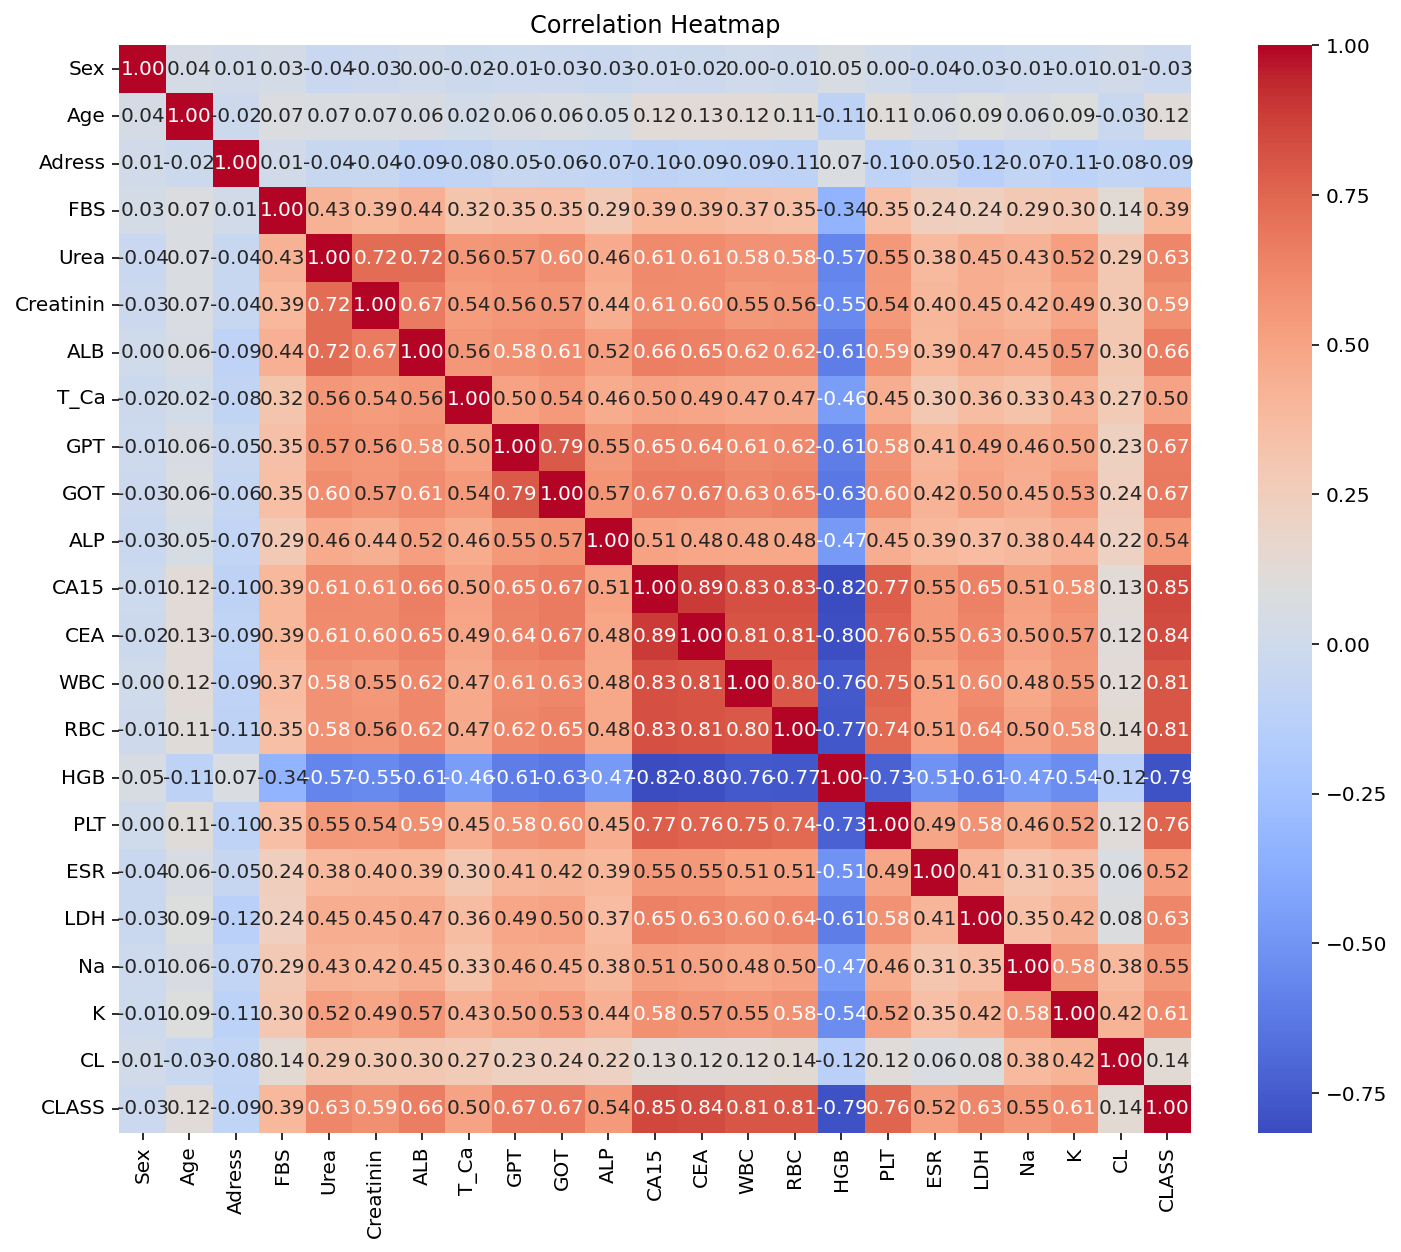

In [85]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### bisogna dire tipo come nelle analisi precendi eccc
Studies show that biomarkers such as CA15 and CEA -link- are already established and well known predictors of benign and malign cancer, and this correlation matrix shows problems in the sense that these two variables re highly correlated with each other, shadowing the effect of other predictors. For this reason we chose to focus our attention towards such predictors.

We begin by removing CA15, since is shows the highest levels of correlation




The correlation heatmap reveals various relationships between variables. Strong correlations exist between biomarkers like **CA15**, **CEA**, **RBC**, and **WBC**, suggesting they are related and may reflect similar physiological processes. Conversely, **CL** and **Na** show weak correlations with most other variables, indicating limited relevance. **HGB** displays a strong negative correlation with others, highlighting distinct relationships. Additionally, **Age**, **Sex**, and **Adress** show weak or no significant correlations with most features, suggesting they might not contribute strongly to the variability in the dataset or the target variable, **CLASS**. These findings highlight the importance of focusing on key biomarkers for further analysis.

## Variance Inflation Factor

In [86]:
# Add a constant (intercept) column to the dataset for calculating VIF
features_const = sm.add_constant(data.drop(columns=['CLASS', 'CA15']))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features_const.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features_const.values, i) for i in range(features_const.shape[1])]

# Display the results
print(vif_data)


      Feature          VIF
0       const 660.94709874
1         Sex   1.01965724
2         Age   1.02831342
3      Adress   1.03677832
4         FBS   1.32345776
5        Urea   2.92353519
6   Creatinin   2.54565117
7         ALB   2.91799404
8        T_Ca   1.76139406
9         GPT   3.01628225
10        GOT   3.34567693
11        ALP   1.71823252
12        CEA   5.04784247
13        WBC   3.94108525
14        RBC   4.11757916
15        HGB   3.56145967
16        PLT   3.02035707
17        ESR   1.52669305
18        LDH   1.88243950
19         Na   1.76369504
20          K   2.19097033
21         CL   1.45404726


CEA shows a VIF value just above the problematic threshold. We chose not to include it because as we've seen before, it is one of the two (uninteresting) biormarkers.

Multicollinearity does not affect the predictive power of the model but makes it difficult to interpret the individual coefficients of the predictors.

We will now proceed with feature selection on the remaining variables.

# Selection, Description and possibly comparison of the most suitable statistical models

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Feature selection (forward selection)

In [88]:
X_f = data.drop(columns=['CLASS'])
y_f = data['CLASS']

# Forward Selection Function
def forward_selection(X, y):
    initial_features = X.columns.tolist()
    selected_features = []
    while initial_features:
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)

        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            new_pval[feature] = model.pvalues[feature]
        
        min_pval = new_pval.min()
        if min_pval < 0.001:  # Set significance level
            selected_features.append(new_pval.idxmin())
        else:
            break

    return selected_features

selected_features = forward_selection(X_f, y_f)
print("Selected features:", selected_features)


Selected features: ['CA15', 'CEA', 'WBC', 'GPT', 'RBC', 'Na', 'HGB', 'ALP', 'PLT', 'Urea', 'CL', 'K']


CEA e CA15 sono importanti perche xyz link jack e decidiamo di rimuoverli perche abc + evidenziamo i problemi di VIF $\\$


proviamo a fare un modello con solo quelle

(modello logistico rapido come ulteriore giustificazione)

In [111]:
# Split the dataset into features and target
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

print(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)


# Initialize the StandardScaler
'''scaler = StandardScaler()

# Fit the scaler to the training data and transform the data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (to avoid data leakage)
X_test_scaled = scaler.transform(X_test)'''


      Sex Age  Adress  FBS  Urea  Creatinin        ALB        T_Ca  GPT  GOT  \
0       1   3       3  100    23 0.80000000 3.40000000 10.00000000   20   10   
1       1   2       3  190    27 0.60000000 4.20000000  9.30000000   11   17   
2       1   2       3  150    15 1.10000000 3.50000000  8.50000000   13   10   
3       1   1       3   80    20 1.00000000 4.20000000  8.00000000    7   13   
4       1   1       3   80    40 0.80000000 3.00000000  9.50000000    9   15   
...   ...  ..     ...  ...   ...        ...        ...         ...  ...  ...   
2430    1   1       3  146    28 0.70000000 4.00000000  9.50000000   63   23   
2431    1   2       3   90    32 0.80000000 4.70000000  8.80000000   82   23   
2432    1   2       3   70    15 0.60000000 3.50000000  8.10000000   22   15   
2433    1   3       3   98    29 0.90000000 4.80000000  8.20000000   51   17   
2434    1   3       3   76    29 0.60000000 4.20000000  8.50000000   83   20   

      ALP        WBC        RBC        

'scaler = StandardScaler()\n\n# Fit the scaler to the training data and transform the data\nX_train_scaled = scaler.fit_transform(X_train)\n\n# Transform the test data using the same scaler (to avoid data leakage)\nX_test_scaled = scaler.transform(X_test)'

## Logistic Regression

In [112]:
# Set the float format to display more decimals
# pd.set_option("display.float_format", lambda x: f"{x:.8f}")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the logistic regression model
log_reg = sm.Logit(y_train, X_train_const).fit()

# Predictions
y_pred = log_reg.predict(X_test_const)
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(log_reg.summary())
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)

Optimization terminated successfully.
         Current function value: 0.149320
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  CLASS   No. Observations:                 1948
Model:                          Logit   Df Residuals:                     1927
Method:                           MLE   Df Model:                           20
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.7828
Time:                        16:25:23   Log-Likelihood:                -290.88
converged:                       True   LL-Null:                       -1338.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3887      3.444     -2.145      0.032     -14.139      -0.639
Sex           -0.9627      2.

In [128]:
def forward_selection(X):
  features = list(X.columns)
  # features.remove("CA15")

  X_const = sm.add_constant(X_train)
  selected_features = []

  best_auc = 0
  max_iteration = len(features)

  for _ in range(0,max_iteration):
    aucs = []
    for feature_2 in features:
      features_to_use = [*selected_features, feature_2]
      log_reg_sm = sm.Logit(y_train, X_const[features_to_use]).fit(disp=0)
      y_train_pred = log_reg_sm.predict(X_const[features_to_use])
      auc = roc_auc_score(y_train, y_train_pred)
      aucs.append(auc)
      
    if max(aucs) - best_auc > 0.001:
      best_feature = aucs.index(max(aucs))
      selected_features.append(features[best_feature])
      best_auc = max(aucs)
      features.remove(features[best_feature])
    
    aucs = []
    
  return selected_features

forward_selection(X_train)

['WBC', 'HGB', 'GPT', 'Na', 'CL', 'K', 'ALP', 'ALB']

In [92]:
from sklearn.metrics import roc_auc_score

# Store AUC scores for each feature
auc_scores = {}

# Loop through each feature
for feature in X_train.columns:
    # Train a model using only this feature
    model = LogisticRegression()
    model.fit(X_train[[feature]], y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_train[[feature]])[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_train, y_prob)
    auc_scores[feature] = auc

# Sort features by AUC
sorted_features = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

# Display ranked features and their AUC scores
for feature, auc in sorted_features:
    print(f"Feature: {feature}, AUC: {auc}")

# Select top features (e.g., top 5 features)
top_features = [feature for feature, auc in sorted_features[:5]]

# Build final model using selected features
final_model = LogisticRegression()
final_model.fit(X_train[top_features], y_train)


Feature: WBC, AUC: 0.9531520789718135
Feature: RBC, AUC: 0.948205675672505
Feature: PLT, AUC: 0.9480323702528979
Feature: HGB, AUC: 0.9455900969550504
Feature: LDH, AUC: 0.8958333111146899
Feature: GPT, AUC: 0.8749550739027634
Feature: ESR, AUC: 0.8715220268522084
Feature: GOT, AUC: 0.8686680865268634
Feature: ALB, AUC: 0.8574538927596729
Feature: ALP, AUC: 0.8515311133886702
Feature: Urea, AUC: 0.8398855224385192
Feature: Creatinin, AUC: 0.8342506966877868
Feature: Na, AUC: 0.8202310881127414
Feature: K, AUC: 0.799206207853455
Feature: T_Ca, AUC: 0.7959752615845341
Feature: CL, AUC: 0.7495432735634047
Feature: FBS, AUC: 0.7384042676859515
Feature: Age, AUC: 0.5616044775721458
Feature: Adress, AUC: 0.5221852266994863
Feature: Sex, AUC: 0.5000309283518067


LogisticRegression()

In [93]:
# Split the dataset into features and target
# X = X.drop(columns=['Age', 'Sex', 'Adress', 'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GOT', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH'])
# y = data['CLASS']

# print(X)
# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

      GPT  ALP        WBC           Na          K           CL
0      20  124 3.40000000 145.00000000 4.50000000 107.10000000
1      11  133 4.40000000 139.20000000 4.17000000 106.40000000
2      13  155 5.10000000 140.00000000 4.00000000 100.10000000
3       7  170 3.10000000 136.40000000 4.06000000 107.10000000
4       9  125 4.20000000 142.30000000 4.00000000 106.20000000
...   ...  ...        ...          ...        ...          ...
2430   63  234 3.90000000 138.70000000 4.35000000 103.60000000
2431   82  190 4.80000000 142.30000000 4.40000000 102.70000000
2432   22  143 4.40000000 137.80000000 4.25000000 110.20000000
2433   51  104 4.50000000 147.50000000 3.15000000 107.50000000
2434   83  178 3.40000000 142.30000000 3.23000000 107.50000000

[2435 rows x 6 columns]


In [94]:
# Set the float format to display more decimals
# pd.set_option("display.float_format", lambda x: f"{x:.8f}")
# pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Add a constant to the model (intercept)
# X_train_const = sm.add_constant(X_train)
# X_test_const = sm.add_constant(X_test)

# Fit the logistic regression model
# log_reg = sm.Logit(y_train, X_train_const).fit()

# Predictions
# y_pred = log_reg.predict(X_test_const)
# y_pred = np.round(y_pred)

# Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(log_reg.summary())
# print("Accuracy:", accuracy)
# print("\nConfusion Matrix:\n", conf_matrix)

Optimization terminated successfully.
         Current function value: 0.166404
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  CLASS   No. Observations:                 1948
Model:                          Logit   Df Residuals:                     1941
Method:                           MLE   Df Model:                            6
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.7579
Time:                        16:17:36   Log-Likelihood:                -324.16
converged:                       True   LL-Null:                       -1338.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9227      1.787     -4.993      0.000     -12.425      -5.420
GPT            0.0277      0.

## Decision Tree

In [95]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=61)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Accuracy:", accuracy_dt)

print("\nConfusion Matrix:\n", conf_matrix_dt)


Accuracy: 0.9486652977412731

Confusion Matrix:
 [[255  17]
 [  8 207]]


## Random Forest

In [96]:
# Initialize and train the model
rf_model = RandomForestClassifier(random_state=61)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Accuracy:", accuracy_rf)

print("\nConfusion Matrix:\n", conf_matrix_rf)


Accuracy: 0.9671457905544147

Confusion Matrix:
 [[260  12]
 [  4 211]]


## Ridge Classifier

In [97]:
from sklearn.linear_model import RidgeClassifier

# Initialize and train the model
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

print("Accuracy:", accuracy_ridge)

print("\nConfusion Matrix:\n", conf_matrix_ridge)


Accuracy: 0.9383983572895277

Confusion Matrix:
 [[259  13]
 [ 17 198]]


## Results

In [98]:
# Results summary for comparison
results = {
    'Logistic Regression': {'Accuracy': accuracy, 'Confusion Matrix': conf_matrix},
    'Decision Tree': {'Accuracy': accuracy_dt, 'Confusion Matrix': conf_matrix_dt},
    'Random Forest': {'Accuracy': accuracy_rf, 'Confusion Matrix': conf_matrix_rf},
    'Ridge Classifier': {'Accuracy': accuracy_ridge, 'Confusion Matrix': conf_matrix_ridge}
}

results


{'Logistic Regression': {'Accuracy': 0.944558521560575,
  'Confusion Matrix': array([[258,  14],
         [ 13, 202]])},
 'Decision Tree': {'Accuracy': 0.9486652977412731,
  'Confusion Matrix': array([[255,  17],
         [  8, 207]])},
 'Random Forest': {'Accuracy': 0.9671457905544147,
  'Confusion Matrix': array([[260,  12],
         [  4, 211]])},
 'Ridge Classifier': {'Accuracy': 0.9383983572895277,
  'Confusion Matrix': array([[259,  13],
         [ 17, 198]])}}

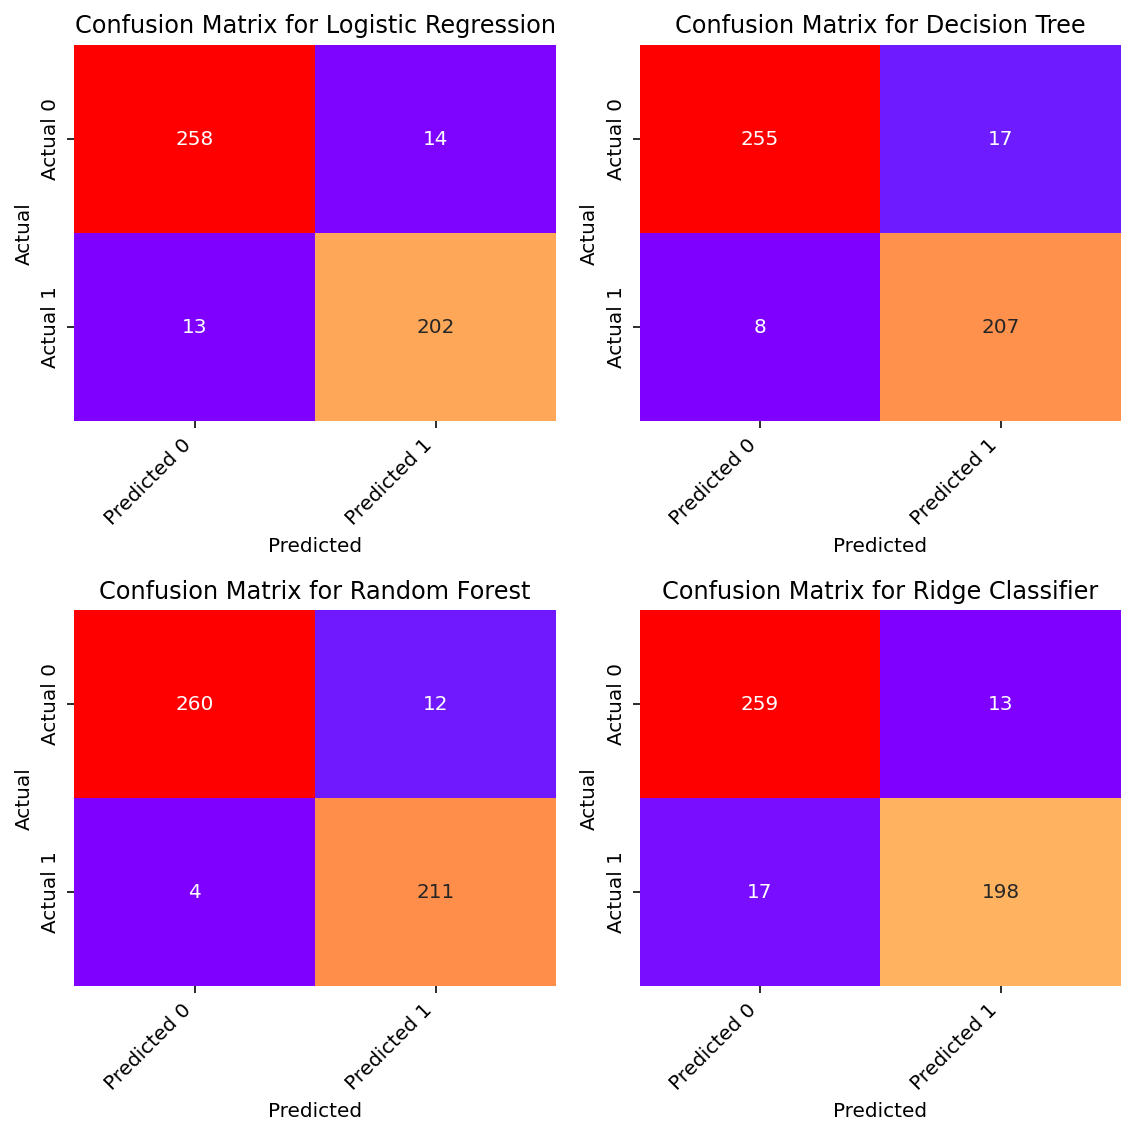

In [99]:
model_names = list(results.keys())

# Visualizing confusion matrices as heatmaps in a 2x2 matrix layout for all models
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Iterate through the models and plot the confusion matrix for each
for i, model in enumerate(model_names):
    conf_matrix = results[model]['Confusion Matrix']
    ax = axes[i//2, i%2]  # Get the appropriate axis
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rainbow', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for {model}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()



# Grafici e alberi se si vuole far vedere se no si toglie

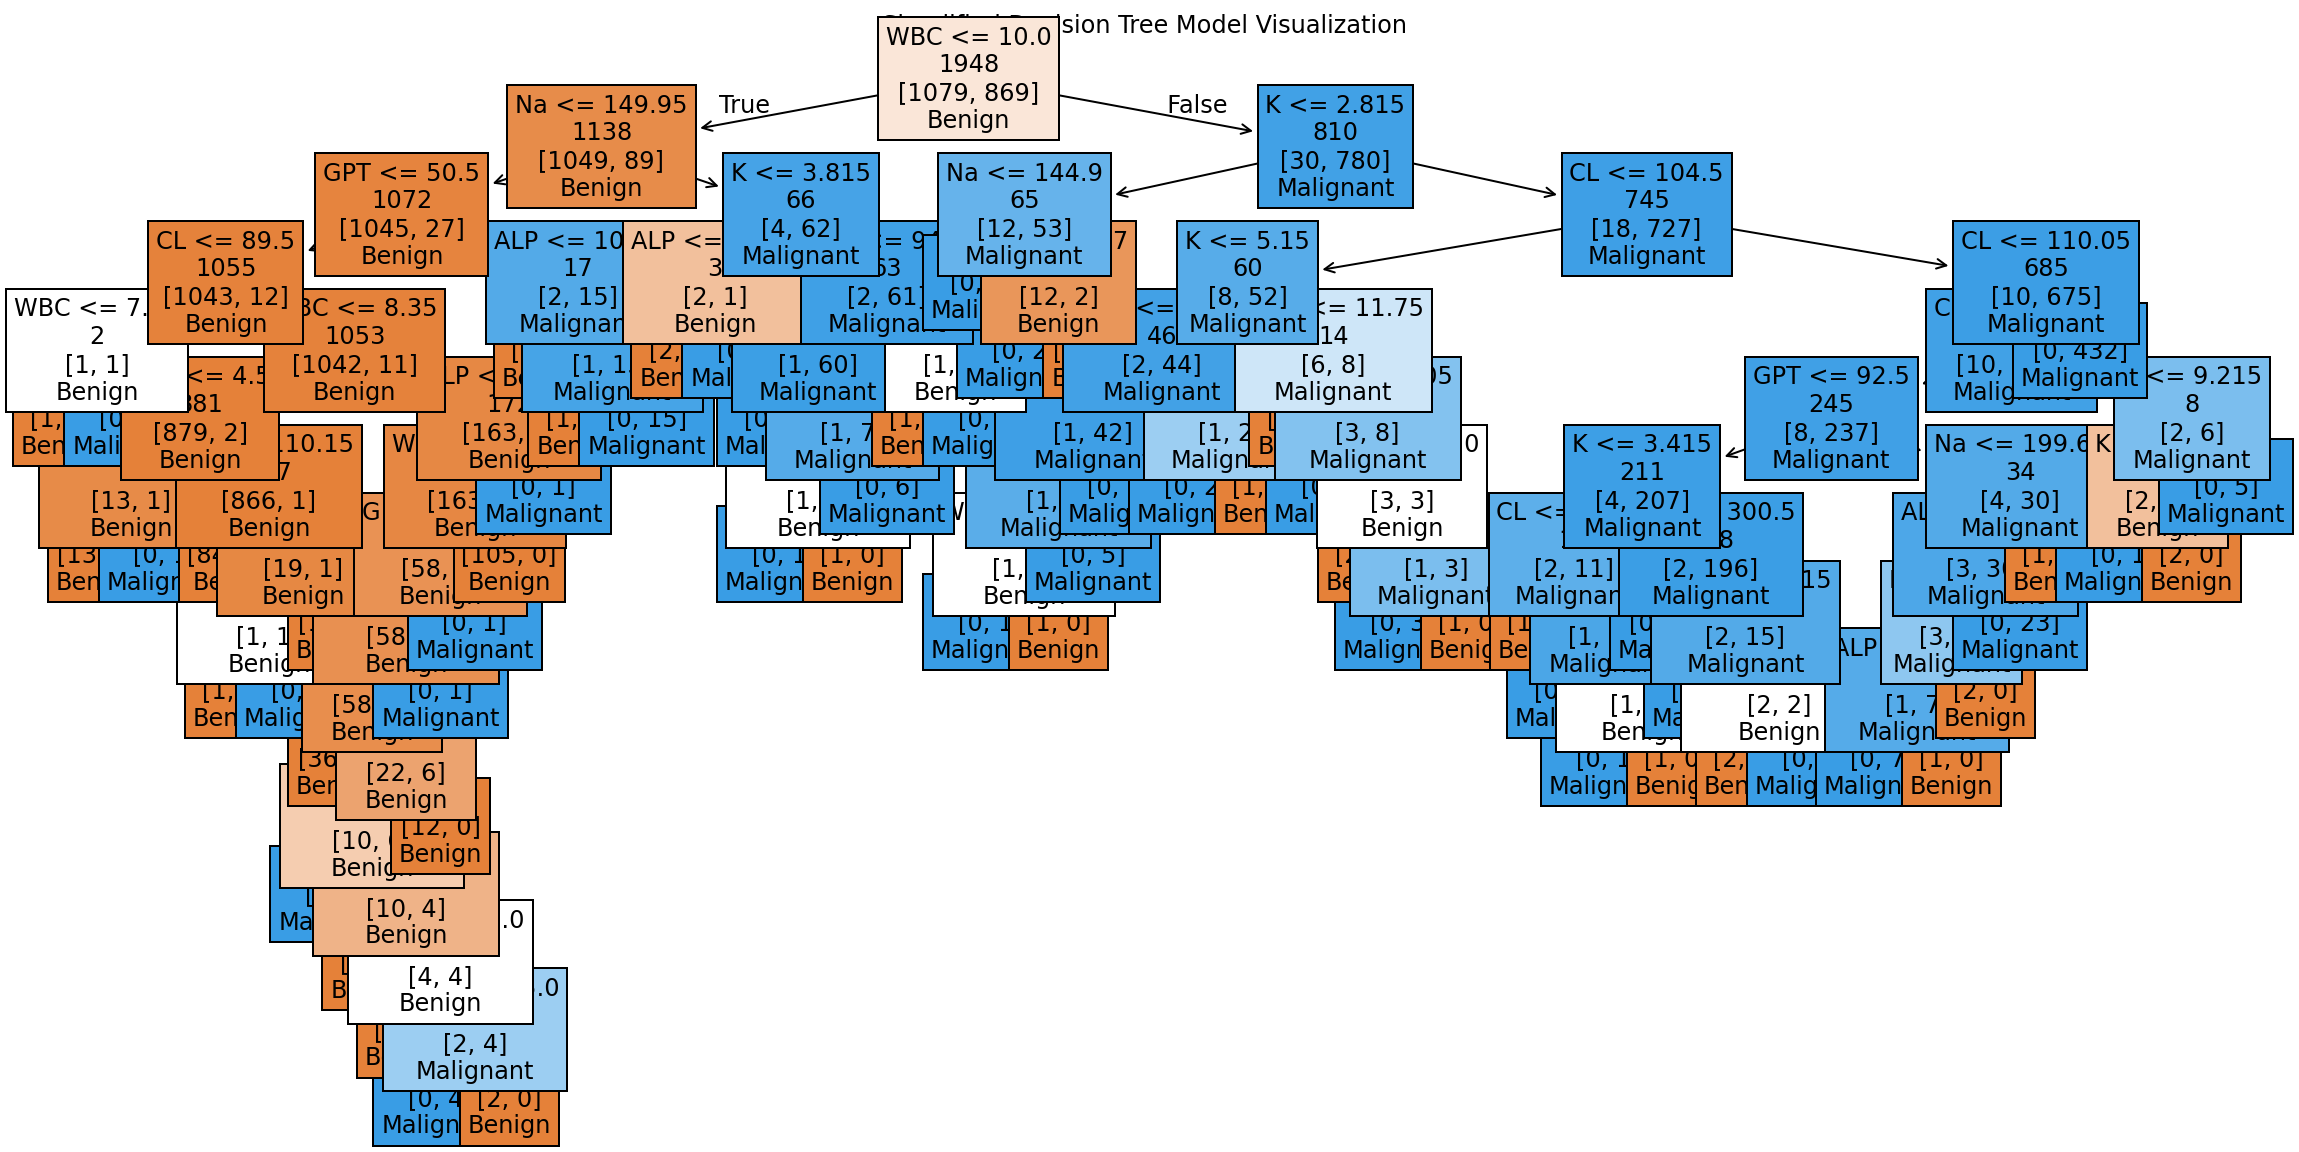

In [100]:
# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Simplified Decision Tree Model Visualization")
plt.show()


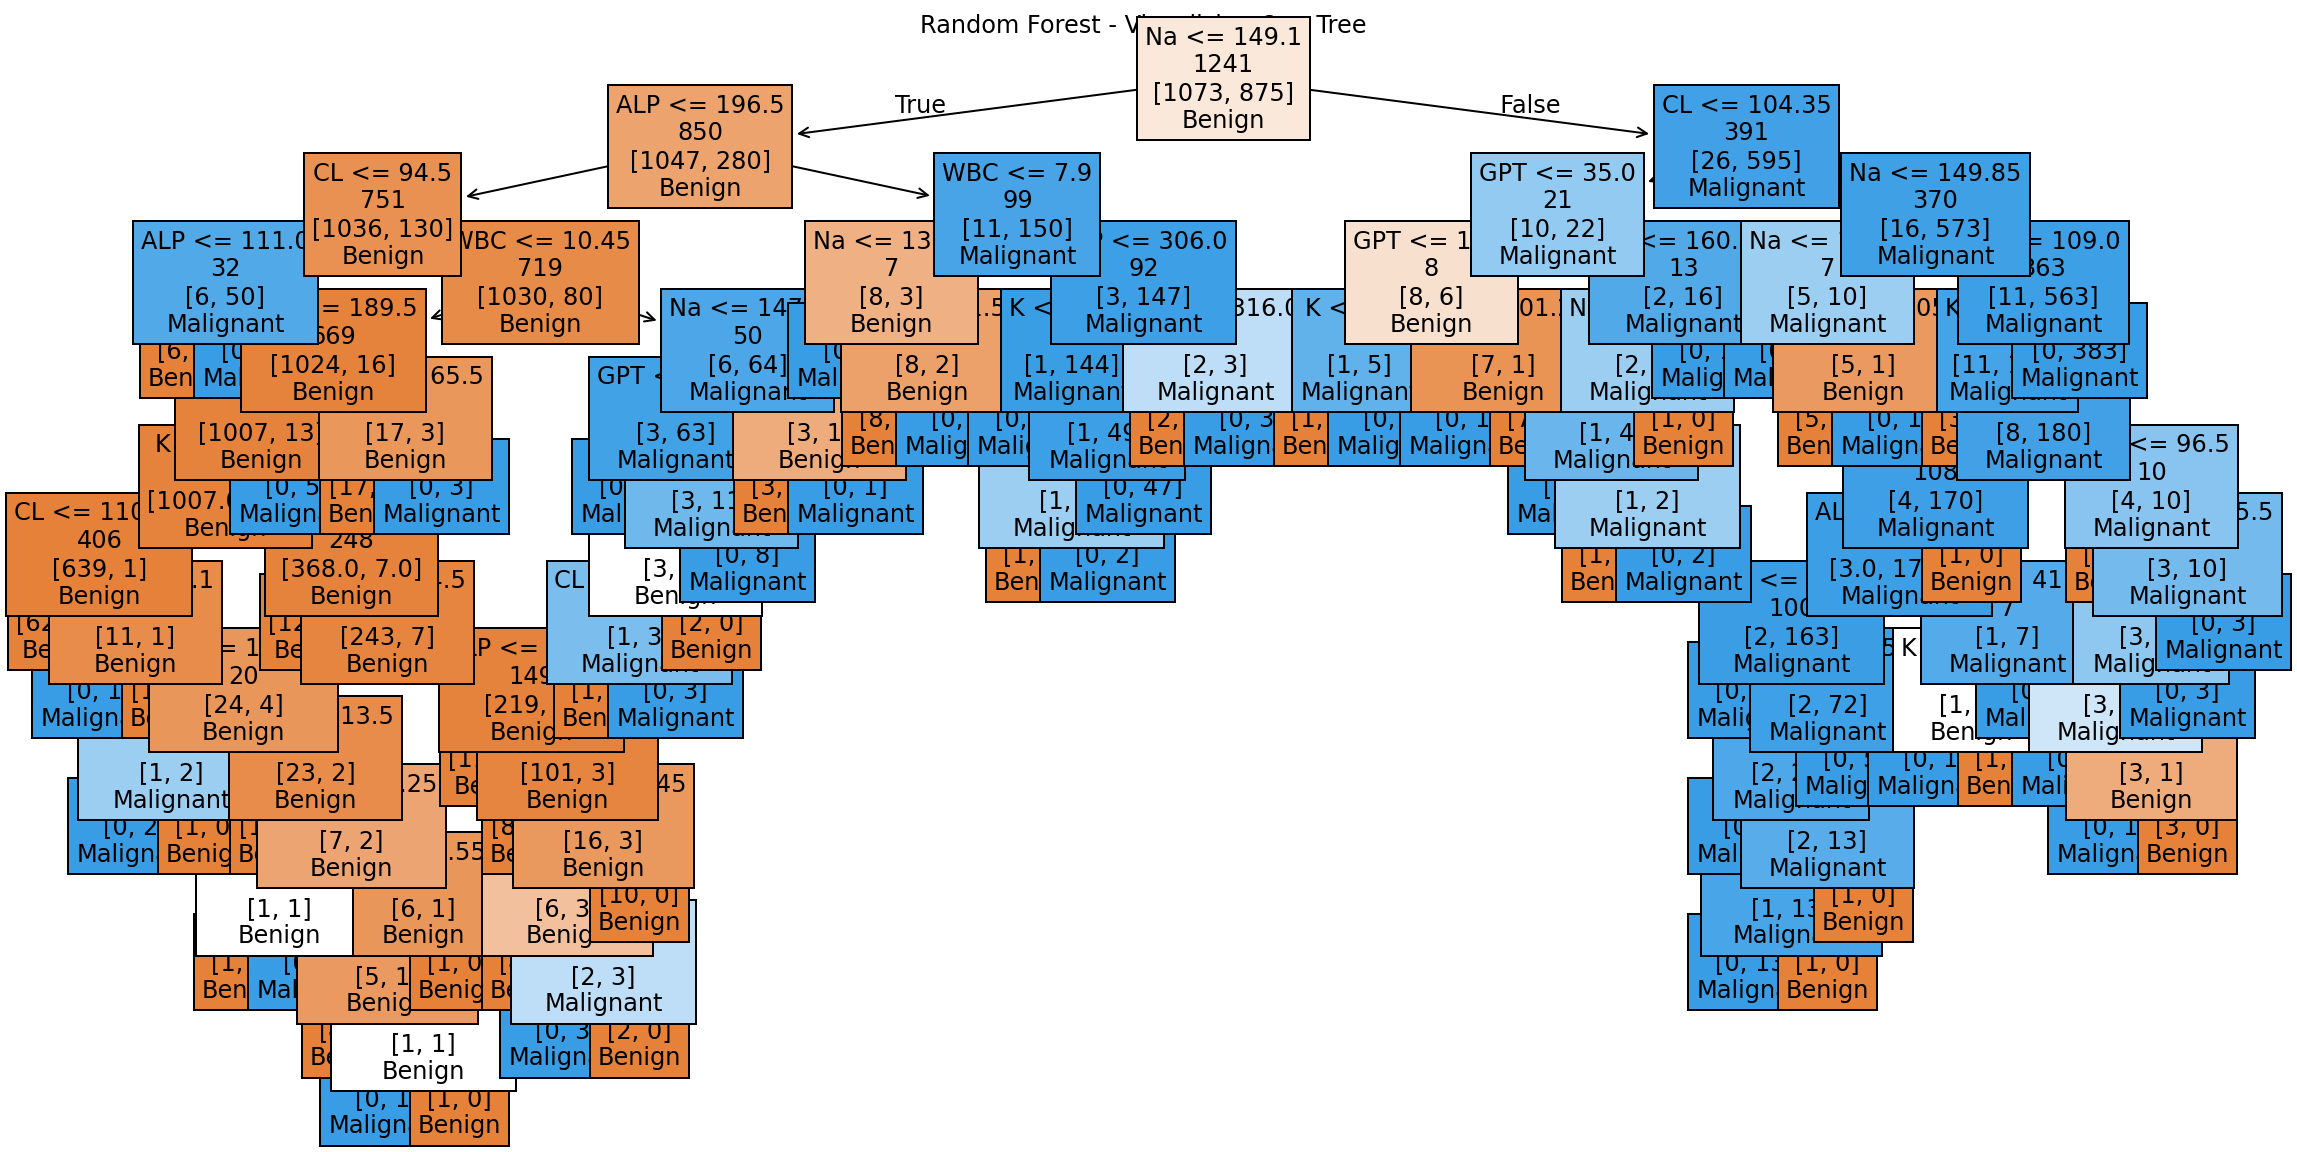

In [101]:
tree_rf = rf_model.estimators_[61]


# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(20, 10))
plot_tree(tree_rf, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Random Forest - Visualizing One Tree")
plt.show()

# GAM   Grandi smeni, smeni duri cazzi amari cazzi in golas

da capire le librerie gam su python


# Comments on results

In [102]:
print('stas si sbooora sulle veline ')

stas si sbooora sulle veline 
